# Modeling tree heights on campus

Tree heights are not directly observed, however we can model their heights with two layers:
1. A height layer showing height of above-ground features, derived from the first return points in a lidar point cloud representing a digital surface model (DSM).
2. A vegetation index showing relative health and density of plants, derived from a normalized difference vegetation index (NDVI) using 4-band NAIP color imagery.

However, the temporal resolution of each layer should be considered. In our first example, we used NAIP imagery from 2022 and a DSM from 2010. How can we make a better model? Let's compare the NAIPs from 2022 and 2022.

In [1]:
import arcpy

In [19]:
# Input database
arcpy.env.workspace = 'C:\\SchimpffGIS\\data\\campus.gdb'
# Define output CRS
ky = arcpy.SpatialReference(3089)
# Set the output CRS
arcpy.env.outputCoordinateSystem = ky
# Enable overwriting exist layers
arcpy.env.overwriteOutput = True

In [20]:
# Let's see what we have in our wokrspace.
features = arcpy.ListFeatureClasses()
rasters = arcpy.ListRasters()

# Show the vector layers
for fc in features:
    print(fc)

# Show the raster layers created from lab 3.
for raster in rasters:
    print(raster)

boundary
min
max
campusDem
ndvi
campusDsm
campusNaip


In [22]:
# Load the layers
naip = arcpy.sa.Raster('campusNaip')
dem = arcpy.sa.Raster('campusDem')
dsm = arcpy.sa.Raster('campusDsm')


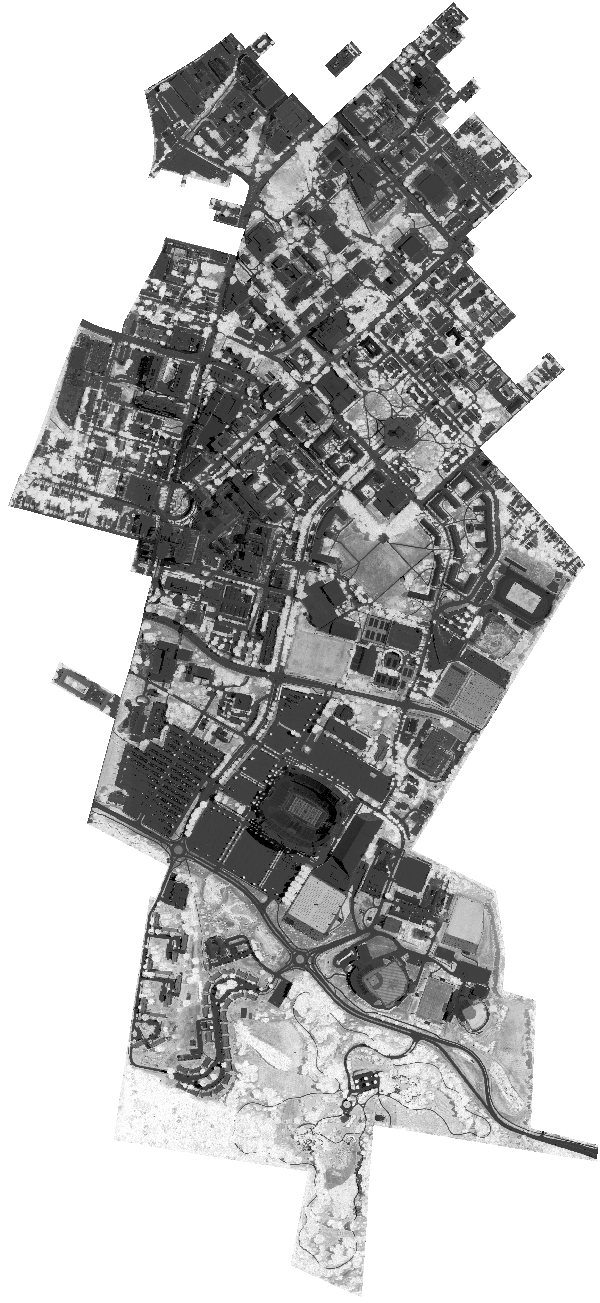

In [23]:
#Create NDVI
ndvi = arcpy.ia.NDVI(naip)
ndvi.save('ndvi')

# Verify
ndvi

In [24]:
height = (dsm - dem)

In [25]:
height.save('height')

In [26]:
ndvi = arcpy.sa.Raster('ndvi')
height = arcpy.sa.Raster('height')

In [5]:
# Don't have a height raster? Create one using map algebra, save it, and then reload the layer.
dsm_dem = (dsm - dem)
dsm_dem.save('campus_height')
height = arcpy.sa.Raster('campus_height')

#SKIPPED

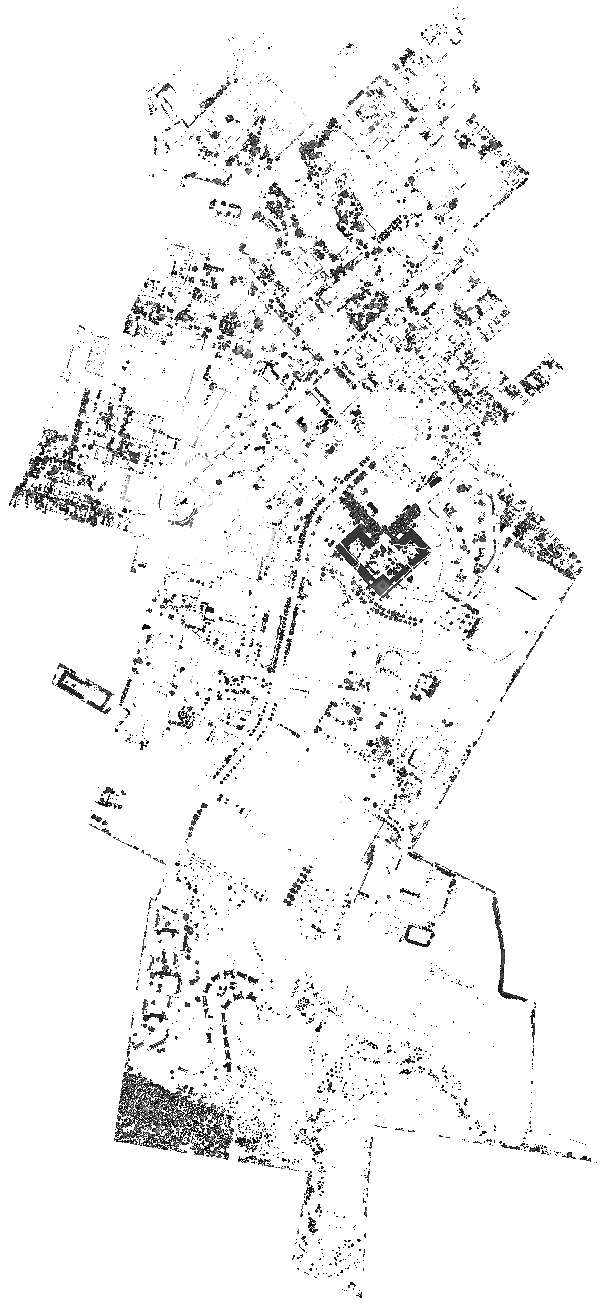

In [27]:
# Calculate the model with NDVI greater than 0.1 and a height greater than 5 feet
trees = arcpy.sa.Con(((ndvi > 0.1) & (height > 5)), height)
trees.save('campus_trees_ndvi_01')
trees

In [28]:
# Reclassify old values to new range
# format [old_lo, old_high, new_value], next new class, etc. 
reramp = arcpy.sa.RemapRange([[5,15,1],[15,35,2],[35,75,3],[75,140,4],[140,300,5]])
trees_classed = arcpy.sa.Reclassify(trees, "Value", reramp, "NODATA")
trees_classed.save('trees_classed_ndvi_01')

In [29]:
# Get height for each new class. Note the record height for a tree in Kentucky is ~165 feet.
resolution = 5
sumCover = 0
with arcpy.da.SearchCursor('trees_classed' , ['Count']) as cursor:
    for row in cursor:
        sumCover += row[0]
with arcpy.da.SearchCursor('trees_classed', ['Count', 'Value']) as cursor:
    for row in cursor:
        a = (row[0]/sumCover) * 100
        b = (row[0] * resolution**2) / 43560
        a = round(a, 2)
        b = round(b, 1)
        c = f'{a}%, {b} acres of {row[1]}'
        print(c)

34.85%, 39.4 acres of 1
47.89%, 54.1 acres of 2
16.25%, 18.4 acres of 3
0.67%, 0.8 acres of 4
0.33%, 0.4 acres of 5


## Create model using a 2010 NAIP

We will need to harvest data from the kyraster.ky.gov ArcGIS Server. First, we should set the processing extent to the boundary AOI in our workspace. Then, we'll need to find the URL for the layer, extract the layer by the boundary, and save the new layer.

In [30]:
# Set the processing extent
arcpy.env.extent = "boundary"

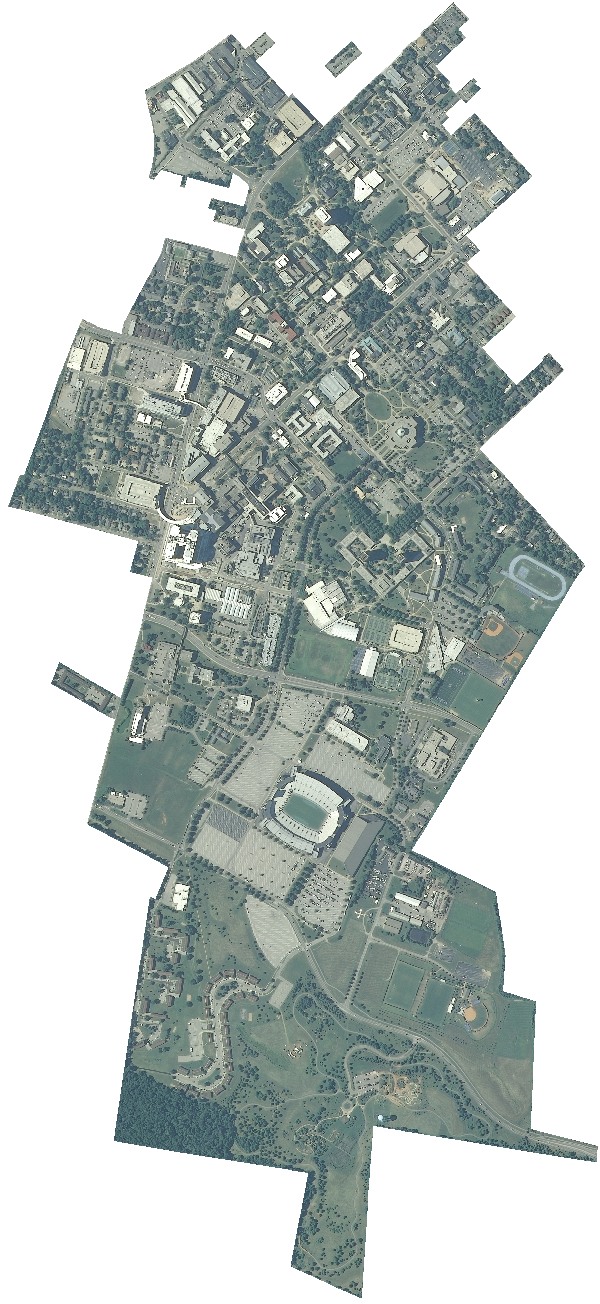

In [31]:
# Harvest the NAIP
naip_2010 = arcpy.sa.ExtractByMask('https://kyraster.ky.gov/arcgis/rest/services/ImageServices/Ky_NAIP_2010_1M/ImageServer', "boundary")
naip_2010.save("naip_2010")
naip_2010

In [32]:
# Release the processing extent
arcpy.env.extent = "maxof"

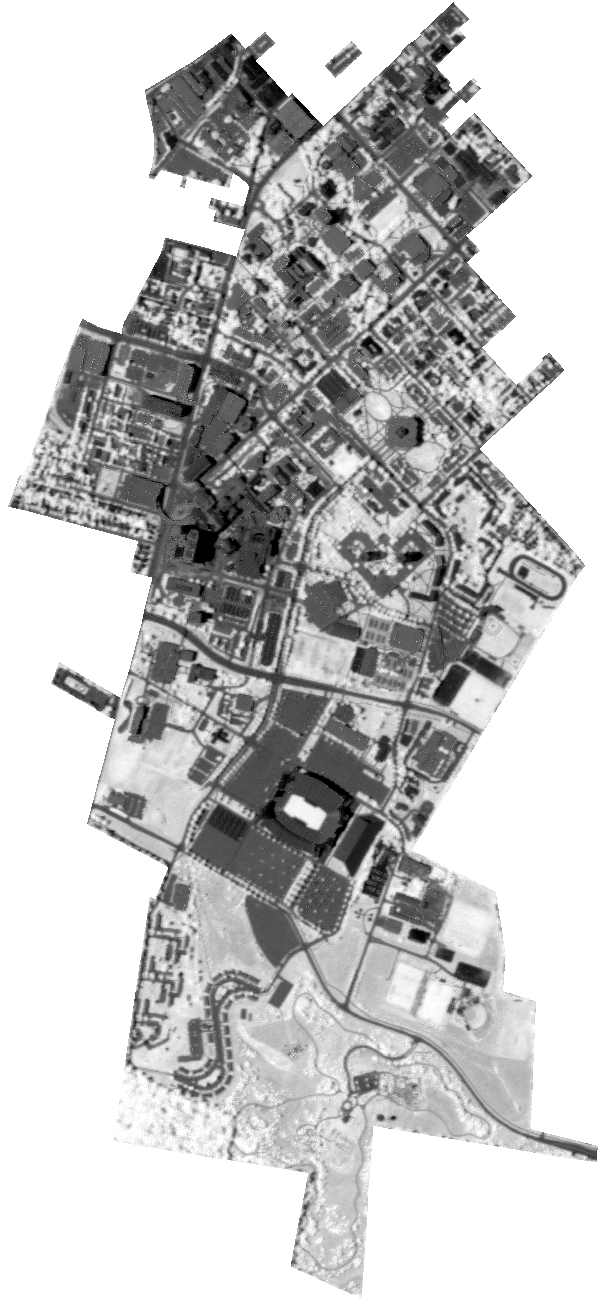

In [33]:
# Create and save the NDVI
ndvi_2010 = arcpy.sa.NDVI(naip_2010)
ndvi_2010.save('campus_ndvi_2010')
ndvi_2010

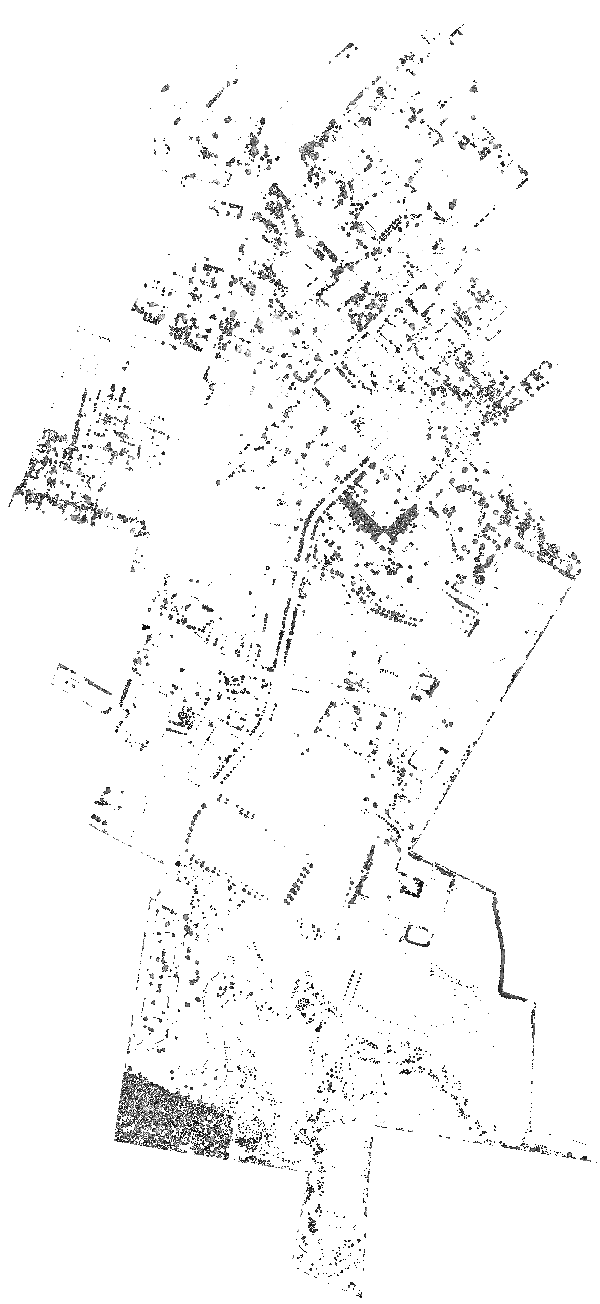

In [34]:
# Create and ave the height model
trees_2010 = arcpy.sa.Con(((ndvi_2010 > 0.1) & (height > 5)), height)
trees_2010.save('campus_trees_2010')
trees_2010

In [39]:
# Reclassify the height layer.
reramp = arcpy.sa.RemapRange([[5,15,1],[15,35,2],[35,50,3],[50,75,4],[75,100,5],[100,150,6],[150,300,7]])
trees_classed_2010 = arcpy.sa.Reclassify(trees_2010, "Value", reramp, "NODATA")
trees_classed_2010.save('trees_classed_2010')

In [36]:
# Run statistics on new layer
sumCover = 0
with arcpy.da.SearchCursor('trees_classed_2010' , ['Count']) as cursor:
    for row in cursor:
        sumCover += row[0]
with arcpy.da.SearchCursor('trees_classed_2010', ['Count', 'Value']) as cursor:
    for row in cursor:
        a = (row[0]/sumCover) * 100
        b = (row[0] * resolution**2) / 43560
        a = round(a, 2)
        b = round(b, 1)
        c = f'{a}%, {b} acres of {row[1]}'
        print(c)

34.32%, 29.9 acres of 1
46.84%, 40.8 acres of 2
18.6%, 16.2 acres of 3
0.24%, 0.2 acres of 4
0.0%, 0.0 acres of 5


ExecuteError: ERROR 010474: The remap table is invalid (check for range overlaps, duplicate entries).
Failed to execute (Reclassify).
